<a href="https://colab.research.google.com/github/HannaKi/Image_classification_with_machine_learning_models/blob/main/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

The purpose of the excercise is to perform image classification for three different kind of images. Images will be either of grass, stairs or sand. 

I will build, train and eventaully compare three separate image classifiers, ie. machine learning algorithms, which are capable of analyising and classifiying a new image representing one of the tree imagetypes we are dealing with in this task. The classifiers are:
- K nearest neighbors algorithm (kNN)
- Regularized linear model
- Multi-layer perceptron (MLP)

The classifiers will be introduced more precisely later on in this report.

All the classifiers I will build use supervised learning. Supervised learning means that I will provide the classifier with images of grass, stairs and sand and also the class of given images. This phase is called training of the classifier. By this way the classifier will learn, what kind of features, for example color or texture, are connected to each of the three image types. 

After training we will feed in the classifier some new data, which does not include the class of the image, only the features. The classifier will classify each image based on the information it gained from the training phase. In the end we will evaluate how well the classifier performed by comparing the true image classes and the classifications the algorithm made.

The images, further refered as the data, I am using are from https://unsplash.com/. Unsplash.com provides data free of charge and without premoission of the photogafer.

## Data preparation

First we will import all packages and modules needed fo the analysis.

In [191]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage as sk
import seaborn as sns

from collections import Counter
from pprint import pprint
from skimage.io import imread
from skimage.transform import resize 
from skimage import img_as_ubyte, color
from skimage.feature import greycomatrix, greycoprops
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold, cross_val_predict
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

Then I will import the data. 

In [108]:
%%bash
wget -nc https://raw.githubusercontent.com/HannaKi/Image_classification_with_machine_learning_models/main/data/Grass.txt
wget -nc https://raw.githubusercontent.com/HannaKi/Image_classification_with_machine_learning_models/main/data/Sand.txt
wget -nc https://raw.githubusercontent.com/HannaKi/Image_classification_with_machine_learning_models/main/data/Stairs.txt

File ‘Grass.txt’ already there; not retrieving.

File ‘Sand.txt’ already there; not retrieving.

File ‘Stairs.txt’ already there; not retrieving.



In [109]:
grass_urls = np.loadtxt('Grass.txt', dtype = 'U150').tolist()
stair_urls = np.loadtxt('Stairs.txt', dtype = 'U150').tolist()
sand_urls = np.loadtxt('Sand.txt', dtype = 'U150').tolist()

In [110]:
# def open_file(file):
#   urls=[]
#   f = open(file)
#   lines = f.readlines()
#   for line in lines:
#     # print(line)
#     # break
#     urls.append(line)
#   return urls
  
# grass_urls = open_file('Grass.txt')
# stair_urls = open_file('Stairs.txt')
# sand_urls = open_file('Sand.txt')

Now we can take a look the data. Let's find out the number of images we are dealing with.

In [111]:
print(f"{len(grass_urls)} images of grass, {len(stair_urls)} images of stairs and {len(sand_urls)} images of sand.")

62 images of grass, 62 images of stairs and 61 images of sand.


The output above means that our three data sets consist of 62, 62 and 61 URLs (web adresses) each addressing an image. Let's take a closer look at the images, one of each type.

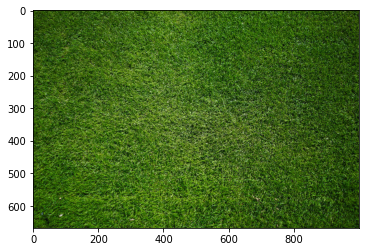

Height in pixels:  668 
Width in pixels:  1000 
Number of color channels: 3


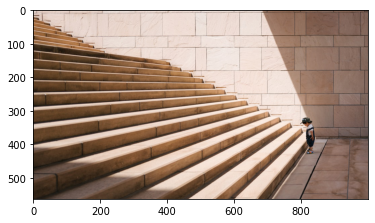

Height in pixels:  563 
Width in pixels:  1000 
Number of color channels: 3


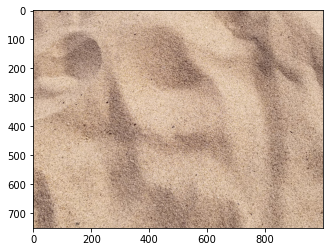

Height in pixels:  750 
Width in pixels:  1000 
Number of color channels: 3


In [112]:
urls = [grass_urls[0], stair_urls[0], sand_urls[0]]

for url in urls:
    image = sk.io.imread(url)
    plt.imshow(image)
    plt.show()
    print("Height in pixels: ", image.shape[0], "\nWidth in pixels: ", image.shape[1], 
              "\nNumber of color channels:", image.shape[2])

Each image consists of height, width and color channels. Thus the image has three dimensions, also known as variables. 

### Resize the images

As we can see, the sizes of the pictures vary. Since I am not interested in this kind of variation, I will resize all the images to same size. I will also fetch the actual images form URLs and store them in one list of images. 

Resizing can be made by cropping the image or by scaling it. Scaling changes the aspect ratio and might squeeze or stretch objects to something unrecognizable. Automatic cropping on the other hand might cut out the essential and is hence more dangerous. Thus I resize the images instead of cropping.

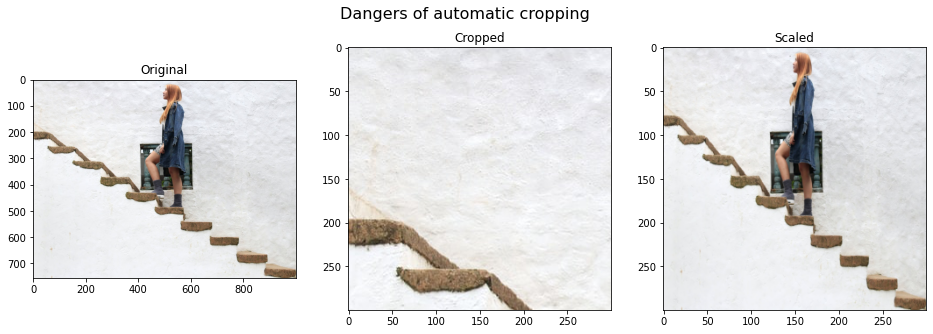

In [121]:
# To crop or to scale down?

image = sk.io.imread(stair_urls[8]) # sample image
image_cropped = image[0:300, 0:300]
image_scaled = img_as_ubyte(resize(image, (300, 300, 3)))

fig, axes = plt.subplots(1,3, figsize=(16,5))
fig.suptitle("Dangers of automatic cropping", fontsize=16)

axes[0].imshow(image)
axes[0].set_title("Original")

axes[1].imshow(image_cropped)
axes[1].set_title("Cropped")

axes[2].imshow(image_scaled)
axes[2].set_title("Scaled");

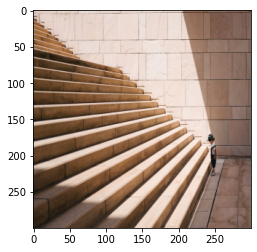

In [120]:
def urls_to_images(urls):
  img = []
  for i in range(len(urls)):
      url = urls[i]
      image = sk.io.imread(url)
      image_resized = img_as_ubyte(resize(image, (300, 300, 3))) # resize here
      img.append(image_resized)
  return img

grass_images = urls_to_images(grass_urls)
stair_images = urls_to_images(stair_urls)
sand_images = urls_to_images(sand_urls)

plt.imshow(stair_images[0]);

We will end up having a list of images instead of URLs. All the pictures have been scaled to size 300 by 300 pixels and each one of them has 3 color channels.

### Augment data

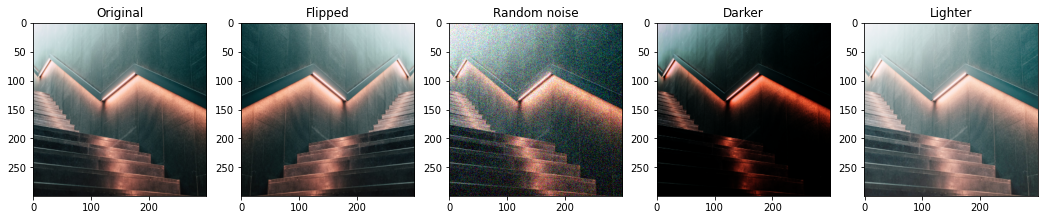

In [124]:
# augment data

# https://scikit-image.org/docs/dev/api/skimage.exposure.html

import numpy as np
from skimage import exposure
from skimage.util import random_noise

image = stair_images[4]

# flip along vertical axis with numpy indexing
flipped_img = image[:, ::-1]
# add random noise
random_noise_img = random_noise(image)
# make darker (gamma > 1)
gamma_darker_img = exposure.adjust_gamma(image, 3)
# make  lighter (gamma < 1)
gamma_lighter_img = exposure.adjust_gamma(image, 0.6)

axes, fig = plt.subplots(1,5, figsize=(18,18))
plt.subplot(1,5,1)
plt.imshow(image)
plt.title("Original")

plt.subplot(1,5,2)
plt.imshow(flipped_img)
plt.title("Flipped");

plt.subplot(1,5,3)
plt.imshow(random_noise_img)
plt.title("Random noise")

plt.subplot(1,5,4)
plt.imshow(gamma_darker_img)
plt.title("Darker")

plt.subplot(1,5,5)
plt.imshow(gamma_lighter_img)
plt.title("Lighter");


In [125]:
for i in range(len(grass_images)):
  image = grass_images[i]
  flipped_img = image[:, ::-1]
  grass_images.append(flipped_img)

for i in range(len(stair_images)):
  image = stair_images[i]
  flipped_img = image[:, ::-1]
  stair_images.append(flipped_img)
  
for i in range(len(sand_images)):
  image = sand_images[i]
  flipped_img = image[:, ::-1]
  sand_images.append(flipped_img)



### Inspect color channels

Pixel is the smallest element of an image. To be precise, an image is a grid of pixels, having height and width, and the intensity of each pixel is a variable. A pixel can have a single intensity value in grayscale images or several channels for color images (https://scikit-image.org/docs/dev/glossary.html). In our case we have three channels: one for red, one for green and one for blue color. This is a typical way to digitally present and store colour images. The intensity value each pixel can have in each channel ranges from 0 to 255. So eventhough we are dealing with images the data is numeric.

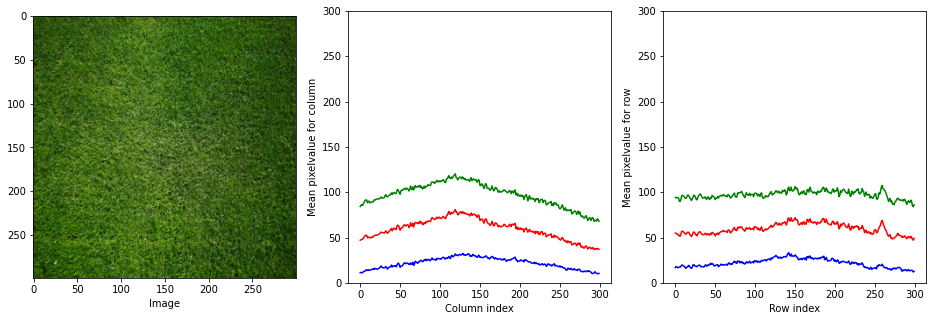

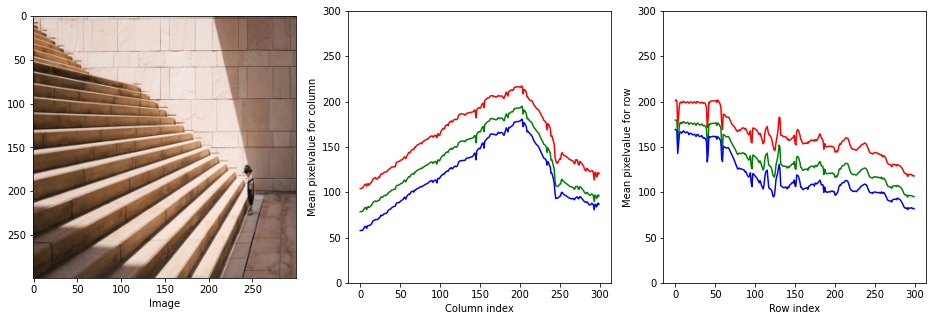

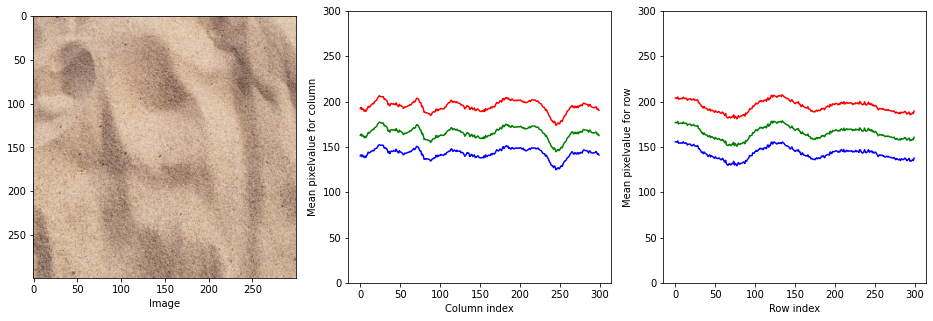

In [126]:
imgs = grass_images[0], stair_images[0], sand_images[0] # Let's pick images (first occurence of each type)

for i in range(len(imgs)):
  image=imgs[i]
  r = image[:, :, 0] # row index, col index, color channel index
  g = image[:, :, 1]
  b = image[:, :, 2]

  axes, fig = plt.subplots(1,3, figsize = (16,5))
  plt.subplot(1,3,1) # subplot(nrows, ncols, index, **kwargs)
  plt.imshow(imgs[i])
  plt.xlabel("Image")

  # Code for plotting the array RGB values from UTU Machine Learning and Patter regocnition 2020 course
  plt.subplot(1,3,2) 
  plt.plot(np.mean(r, axis = 0), "r")
  plt.plot(np.mean(g, axis = 0), "g")
  plt.plot(np.mean(b, axis = 0), "b")
  plt.xlabel("Column index")
  plt.ylabel("Mean pixelvalue for column")
  plt.ylim([0,300])

  plt.subplot(1,3,3)
  plt.plot(np.mean(r, axis = 1), "r")
  plt.plot(np.mean(g, axis = 1), "g")
  plt.plot(np.mean(b, axis = 1), "b")
  plt.xlabel("Row index")
  plt.ylabel("Mean pixelvalue for row")
  plt.ylim([0,300])

From the images above we can see the most dominant color channel for each of the images and also how the values fluctuate following the pattern in the image.


### Grayscale images

Later on during this analysis I will be observing the texture of the images. Texture means more or less repetitive patterns or lack of them in the image. For this purpose I will transform the images to grayscale. I will also reduce the image quantization level, which means that I pack the images. Compressing the images makes analysing them easier since by doing so we deliberately loose some of the excessive informetion (also known as noise) in the images. At this point requantizised grayscaleimages will be stored in a sepatare list.

In [127]:
images = grass_images+stair_images+sand_images
images = np.array(images)

# transforming to grayscale
grayscale = img_as_ubyte(color.rgb2gray(images))

# function to quantizize the images:
def quantizize(x):
    a = x/(np.ceil((np.amax(x)-np.amin(x))/8))
    a = np.array(a, dtype="uint8")
    return a
  
q_images = quantizize(grayscale)   

Now that the transformations have been done, let's take a look at the some sample images. We can see below, that by leaving out the color channels we are able to examine the **luminance** of the images. After quantization the images are also some what more "coarse".

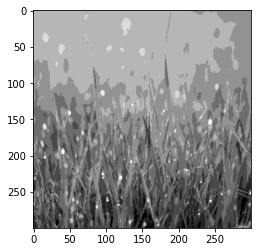

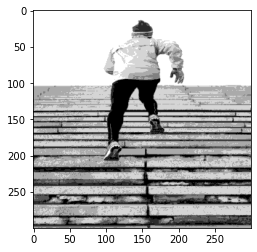

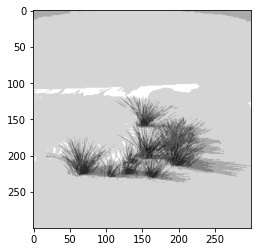

In [137]:
indices = (4, 134, 263)

for i in indices:
    im = q_images[i]
    plt.imshow(im, cmap=plt.cm.gray) # parameter cmap is not neccessary but it highlights that 
                                       # we are not interested in the color but luminance
    plt.show()

## Feature extraction

Feature extraction is the process where we truly extract new features (variables) from the existing data. These new features may compress something essential about the images, something we can use for the upcoming classifications. Feature extraction usually is an iterative process. After the classifications have been done and evaluated we might conclude that the features used were not sufficient or informational at all which forces us to extract more features and perfofm the analysis over again.

### First order texture measures (6 features)

As stated previously, images consist of three separate color channels and pixels have an integer value for each of these channels. This means we can calculate basic statistics with pixel values and use them as  features, which will be given to the classifiers.

Next we will abstract mean and variance of each RGB color channel for all of the images. These values are stored in separate lists.

In [138]:
channel_r_mean = []
channel_g_mean = []
channel_b_mean = []

for i in range(len(images)):
    avg = np.mean(images[i, :, :, 0])
    channel_r_mean.append(avg)
    avg = np.mean(images[i, :, :, 1])
    channel_g_mean.append(avg)
    avg = np.mean(images[i, :, :, 2])
    channel_b_mean.append(avg)
    
channel_r_var = []
channel_g_var = []
channel_b_var = []

for i in range(len(images)):
    avg = np.var(images[i, :, :, 0])
    channel_r_var.append(avg)
    avg = np.var(images[i, :, :, 1])
    channel_g_var.append(avg)
    avg = np.var(images[i, :, :, 2])
    channel_b_var.append(avg) 

### Second order texture measures

Gray-Level-Co-Occurrence (GLCM) is a way to measure texture or the lack of it in the image. If the image is rough we will have large difference between high and low points, i.e. brightness values. On the other hand if the image is silky or smokey there will be only little difference between high and low points. We will look at the pixel correlation value. This means that we define a distance in pixels and compare the brightness of pixels from within this distance to each other. If the correlation is high, we have discovered a pattern. 

As Hall-Beyer points out, "[i]t is expected that different objects will have different characteristic texture measures. To capture this, the window [distance] must be smaller than the object, but big enough to cover the characteristic variability of the object." (Source: Mryka Hall-Beyer, 2017, GLCM TEXTURE: A TUTORIAL. p. 45. URL: http://dx.doi.org/10.11575/PRISM/33280  Refered on 2020-02-15). We also need to take in consideration that "[p]ixels are usually more highly correlated with pixels nearby than with more distant pixels" (Source: prev. p. 43).

Since I have different kind of images in the data set, I aim to answer the queston how often different combinations of pixel brightness values occur in different kind of images? One feature is simply not enough, so we will be searching for horizontal (0°) and vertical (90°) texture in the images both with different values for distances. 

Some of our images have granulous texture, for example close images to grass or sand. For these patterns smaller distances could be useful but this may be cancelled because of pixelautocorrelation discussed above.

Stairs mainly have horizontal lines, the steps. Here we can assume, that horizontal pixel correlation stays high even if the distance is relatively big. Vertical pixel correlation depends on how close to the stairs the picture has been zoomed. Since grass grows, close up images of grass have horizontal lines and rather big vertical distance is beneficial. 

Images taken of sand have wavy patterns. For close up images we would benefit of relatively big vertical and horizontal distances to spot the waves. In many cases images of sand have the same pattern as images of stairs. In the case of stairs the transition from pixel to another pixel with the same gray value is not smooth as it is in the case of sand but this is not visible to the algorithm.

Features can be crafted manually but for my purposes it is easier to extract them in execssive amounts and select the best during model cross validation. It is important not to select the most prominent looking variables before training the model because one would end up making decisions with the whole data (which includes the training data) and thus corrupt the training. 

In [139]:
def horizontal_texture(image, pixel_distance):
  glcm = greycomatrix(image, distances=[pixel_distance], angles=[0], symmetric=True, normed=True, levels = 8) 
  return glcm

def vertical_texture(image, pixel_distance):
  glcm = greycomatrix(image, distances=[pixel_distance], angles=[90], symmetric=True, normed=True, levels = 8) 
  return glcm

def diagonal_texture(image, pixel_distance):
  glcm = greycomatrix(image, distances=[pixel_distance], angles=[45], symmetric=True, normed=True, levels = 8) 
  return glcm

print("Sample Gray-Level-Co-Occurrence matrix:")
glcm = horizontal_texture(q_images[1], pixel_distance=20)
print(type(glcm))
print("Shape:", glcm.shape)

Sample Gray-Level-Co-Occurrence matrix:
<class 'numpy.ndarray'>
Shape: (8, 8, 1, 1)


In [150]:
texture_features = [] # this will be a list of lists
f_names=[]

for distance in range(0, 300, 30): 
  h_dissimilarity=[]
  h_correlation=[]
  # f_names.append("h_" + str(distance) + "_dissimilarity")
  f_names.append("h_" + str(distance) + "_correlation")
  v_dissimilarity=[]
  v_correlation=[]
  # f_names.append("v_" + str(distance) + "_dissimilarity")
  f_names.append("v_" + str(distance) + "_correlation")
  d_correlation=[]
  f_names.append("d_" + str(distance) + "_correlation")
  for image in q_images:
    glcm = horizontal_texture(image, pixel_distance=distance)
    # h_dissimilarity.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    h_correlation.append(greycoprops(glcm, 'correlation')[0, 0])
    glcm = vertical_texture(image, pixel_distance=distance)
    # v_dissimilarity.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    v_correlation.append(greycoprops(glcm, 'correlation')[0, 0])
    glcm = diagonal_texture(image, pixel_distance=distance)
    d_correlation.append(greycoprops(glcm, 'correlation')[0, 0])
  
  # texture_features.append(h_dissimilarity)
  texture_features.append(h_correlation)
  # texture_features.append(v_dissimilarity)
  texture_features.append(v_correlation)
  texture_features.append(d_correlation)

print()
print(f"Number of new features generated: {len(texture_features)}")


Number of new features generated: 30


## Final data preparations

Now we will gather the extracted features:
- Mean for each RGB color channel 3 kpl
- Variance for each RGB color channel 3 kpl
- pixel correlation and dissimilarity in horizontal and vertical directions for given pixel distances

into an input array X. 

Features in this array will be standardized. This will be done since the data analysis techniques we will be using are sensitive to the scale of the measurement unit. For standardizing we will use so called z-score standardization: When standardized, the mean value of variable is set to zero. A negative z-score indicates that a value is less than the mean and a positive z-score indicates the value is greater than the mean. 

In [273]:
colnames = ['red mean', 'green mean', 'blue mean', 'red var', 'green var', 'blue var']

X_raw = pd.DataFrame(list(zip(channel_r_mean, channel_g_mean, channel_b_mean, 
                             channel_r_var, channel_g_var, channel_b_var)), 
                    columns = colnames)

texture_feats = pd.DataFrame(texture_features).transpose()
texture_feats.columns=f_names

all_featurenames=colnames+f_names
X = pd.concat([X_raw, texture_feats], axis=1)

# scale
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=all_featurenames)

print(X.head(5))

# shape of the data set
print(X.shape)

   red mean  green mean  ...  v_270_correlation  d_270_correlation
0 -1.318187   -0.683079  ...           0.794491           0.422265
1 -0.153630    0.335000  ...          -1.240326          -1.438432
2 -2.048212   -0.947756  ...           1.074701           1.224333
3 -0.509802   -0.184966  ...          -0.397314          -0.366610
4 -0.337262    0.643991  ...          -0.906259          -1.333139

[5 rows x 36 columns]
(370, 36)


We will also gather image classes, also known as labels, to a separate output array y. Thus this array will contain the information whether the image is of grass, stairs or sand.

In [274]:
y = ['grass'] * len(grass_images) + ['stair'] * len(stair_images) +['sand'] * len(sand_images)
type(y)

list

In [275]:
# shuffle the data

X['labels']=y
X=X.sample(frac=1)
y=X['labels']
X.drop('labels', inplace=True, axis = 1)
print(X.shape)
y=y.to_list()

(370, 36)


## Feature relationships

### Pairplot
    
For illustrative purposes I make a copy of the data with the labels. I only use the first variables since pairplot gets unclear if it made with too many variables. 

By plotting pairplots we can visually observe possible linear or non-linear dependencies in our data. 

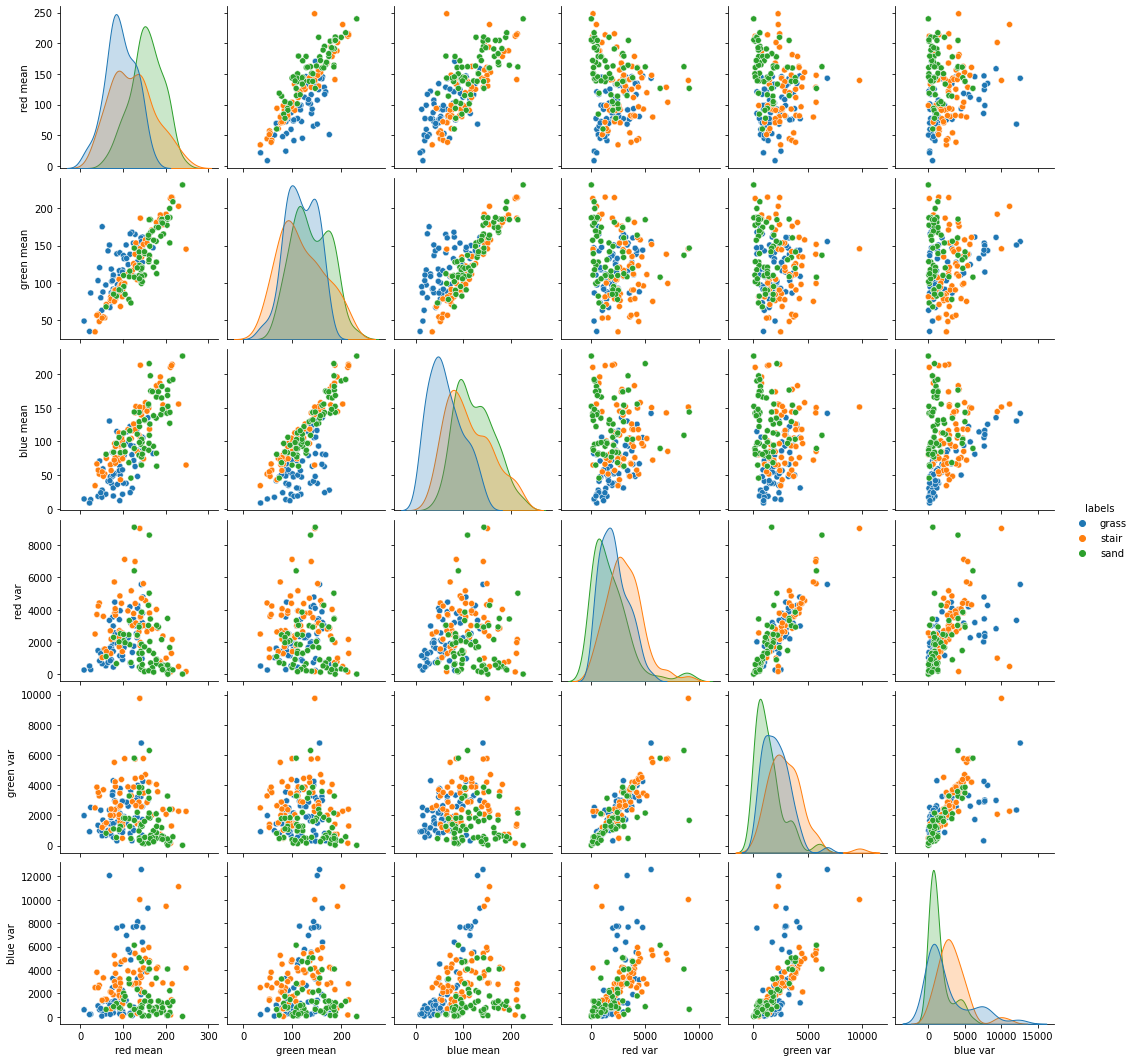

In [229]:
x_copy = X_raw.copy()
x_copy['labels'] = y
sns.pairplot(x_copy , hue='labels')
plt.show()

By examining the pairplot we can see, that mean values of red, green and blue as well as their variances have rough linear dependencies. 

Same correlation and correlations with all of the variables can be spotted by looking at the correlation matrix below.

If two features have linear correlation, it means they carry same kind of information for linear data analysis methods such as Principal Component Analysis, which I will perform soon. For our further purposes we would like to have as many as possible features which do not correlate.  

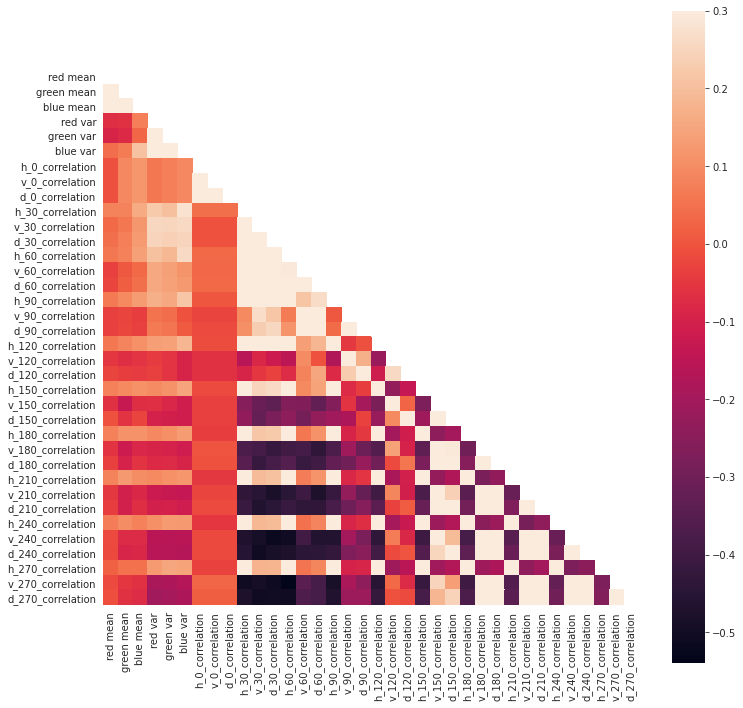

In [153]:
# Pearson is only for linear correlation! For non-linear correlation use Kendall's tau correlation.
#
# Code for masked correlation matrix from: https://seaborn.pydata.org/generated/seaborn.heatmap.html

corr = X.corr(method ='kendall')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)

### PCA

Principal component analysis (PCA) detects the most important dimensions (variables) of the data. It aims to compress the data and still keep as much variance as possible. To do this, PCA observes the covariances of the variables and combines those with similar variances to new "components", which can be interpreted as the new axis of the data. PCA is a dimensionality reduction method since the original variables of the data are compressed to these new components.

For PCA I have followed this tutorial: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

We will keep two most important components so that we are able to plot 2D-image.

In [154]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

labeledDf = pd.concat([principalDf, x_copy['labels']], axis = 1)

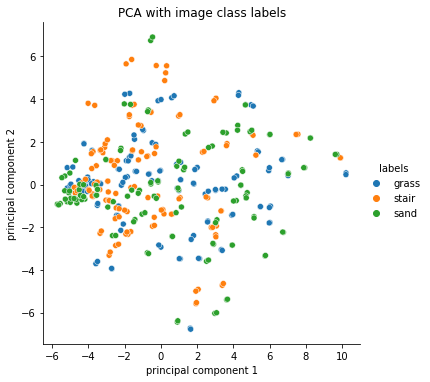

In [155]:
sns.relplot(data=labeledDf, x='principal component 1',y='principal component 2', hue='labels')
plt.title("PCA with image class labels")
plt.show()

The data is scattered in the image above and there are no clusters. This means the first two (and most informative) components do not contain enough information to make any observations of the data structure. 

As stated, PCA aims to compress data and at the same time preserve as much of the variance as possible. Even though PCA might reveal something about the data structure we should not rely solely on it when our purpose is to classify. As Theodoridis et al. point out, "dimensionality reduction is not optimized with respect to class separability" (Source: Theodoridis, Sergios, et al. Pattern Recognition, Elsevier Science & Technology, 2008. ProQuest Ebook Central, p. 329 http://ebookcentral.proquest.com/lib/kutu/detail.action?docID=534973. Refered on 2020-03-09).

We can state that PCA is not the optimal method for classification and it's performance does not imply that classifiying the images with other algorithms could not succeed. 

However PCA can be used to preprocess noisy data before proper classification.

## Build classifiers and estimate their performance

### Cross validation

For model selection I will use nested cross validation, where the model and variables are selected in the inner loop and tested in the outer loop with data which has not been a part of the model and variable selection process. 

As stated before, CV is the right place to do feature selection. I will use sklearn SelectKBest algorithm with analysis of variance for each of the variables. I find this approach simple and suitable for normalized data. Other approaches are also available in Sklearn library. 

I use stratified K-fold cross validation. For K-fold I had to decide how many splits I do for the data, i.e. to how many subsets the data is divided to. Cross validation grows computationally heavy if the number of trialed hyperparameters is large or the data is folded many times. For these reasons I experimented with modest number of hyperparameters and 10 folds in inner and outer CV. 

Stratification takes care that the folds are made by preserving the percentage of samples for each class, (in our case approximately 33, 33 and 33 percent). I also suffle the data before splitting. These measures are taken to ensure that the data in each fold is of the same quality and I train the model with balanced data in each step.

In search for the optimal hyperparameters I will set up a range of possible values and feed it to the algorithm. Other hyperparameters affecting the performance are number of folds and variables. 

### Ridge regression

Next I will build Regularized linear regression model, Ridge regression. 

For multi-class classification, as many classifiers are built and trained as we have data labels in the training data. In this case this means three classifiers: one for grass, one for sand and one for stairs. The classifiers are trained in a one-versus-all approach. After the training each one of the classifiers will "vote" whether an image belongs to the class the classifier predicts or not. The image will be assigned to class with highest predicted value. 

Ridge regression aims to punish for building too complex models which do not generalize well on new, unseen data. Penalizing also prevents giving too much importance for one input value over the others. The alpha parameter, learning  rate, of the model takes care of this regularization. In search for an optimal learning rate we will set up an exponential grid for the hyperparameter and feed it to our algorithm. These values are stored in "param" variable below.

In [243]:
# values to be adjusted:
hyperparam = np.logspace(-4, 4, base = 2, num = 15)
n_feats = 14 # number of features to be selected
folds = 20

# store results
y_true = []
y_preds_K = [] # predictions with outer CV data
best_hyperparam_K = [] # best hyperparameter values according to the accuracy with outer CV data
best_features = [] # features that give the best outer loop predictions

# other adjustments
y=pd.DataFrame(y)
hyperparam_range = hyperparam
kfold_cv = KFold(n_splits=folds, shuffle=True)
outer_fold = 0

# and go!
for train_index, test_index in kfold_cv.split(X):

    outer_fold = outer_fold+1
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    scores = [] # for each hyperparameter store mean accuracy score
    features = [] # for each hyperparameter store features used

    for param in hyperparam_range: # Inner CV: optimize hyperparameter
        inner_scores=[] # for a given hyperparam: accuracy score for each fold
        feat_support=[] # for a given hyperparam: features used to gain the score

        for subtrain_index, subtest_index in kfold_cv.split(X_train):           
            X_subtrain, X_subtest = X_train.iloc[subtrain_index], X_train.iloc[subtest_index]
            y_subtrain, y_subtest = y_train.iloc[subtrain_index], y_train.iloc[subtest_index]
            
            # feature selection
            selector = SelectKBest(f_classif, k=n_feats)
            X_subtrain_new = selector.fit_transform(X_subtrain, y_subtrain)
            # select same feats for test
            X_subtest_new = selector.transform(X_subtest)

            model = RidgeClassifier(alpha=param)
            model.fit(X_subtrain_new, y_subtrain)
            inner_scores.append(model.score(X_subtest_new, y_subtest)) # Test accuracy for each inner fold
            feat_support.extend(selector.get_support(indices=True)) # get votes for the features used in selecting the hyperparam

        # print(f"Feature support for hyperparam value {k:0.2f} is {feat_support}") # best feats of the inner loopa are the most common ones in this list
        # print(f"Mean score for hyperparam value {k:0.2f} is {(np.mean(inner_scores)):0.2}")
        scores.append(np.mean(inner_scores)) # mean of inner scores
        features.append(feat_support) # most used features (occurences not counted yet!)
        # features.append(Counter(feat_support).most_common(n_feats)) # the most used features in inner loop

    # back to outer loop, store best hyperparam and best features and predict with them:  
    print("-------")
    print(f"Outer fold number {outer_fold}")
    print(f"The best hyperparam is {hyperparam_range[np.argmax(scores)]:0.2f}")
    print(f"It was selected with features {features[np.argmax(scores)]}") # get the votes by counting occurences

    best_hyperparam_K.append(hyperparam_range[np.argmax(scores)]) # for the given outer loop fold store the best hyperparameter 
    best_features.append(features[np.argmax(scores)])
    # best_features.append(Counter(features).most_common(n_feats))
    feature_indices = [a for (a, b) in Counter(features[np.argmax(scores)]).most_common(n_feats)] # get the most used features
    

    model = RidgeClassifier(alpha=hyperparam_range[np.argmax(scores)]) # initialize a model with the best hyperparam
    model.fit(X_train.iloc[:,feature_indices], y_train) # train it with the best features
    predictions = model.predict(X_test.iloc[:,feature_indices]) # predict wit the same features
    print(f"Performance accuracy was {round(accuracy_score(y_test[0], predictions)*100,1)} percent")
    print("-------\n")

    y_preds_K.extend(predictions) # store predictions...
    y_true.extend(y_test[0].tolist()) # ...and accuracies for later performance measure

-------
Outer fold number 1
The best hyperparam is 2.21
It was selected with features [0, 1, 2, 3, 4, 5, 15, 18, 21, 28, 29, 32, 34, 35, 0, 1, 2, 3, 4, 5, 15, 18, 21, 24, 28, 29, 31, 32, 0, 1, 2, 3, 4, 5, 15, 18, 21, 24, 28, 31, 34, 35, 0, 1, 2, 3, 4, 5, 15, 18, 21, 24, 28, 29, 32, 35, 0, 1, 2, 3, 4, 5, 15, 18, 21, 24, 28, 29, 31, 35, 0, 1, 2, 3, 4, 5, 15, 18, 21, 28, 29, 31, 32, 35, 0, 1, 2, 3, 4, 5, 15, 18, 21, 24, 28, 29, 31, 35, 0, 1, 2, 3, 4, 5, 15, 18, 21, 24, 28, 31, 34, 35, 0, 1, 2, 3, 4, 5, 15, 18, 21, 28, 29, 31, 32, 35, 0, 1, 2, 3, 4, 5, 15, 18, 21, 24, 28, 31, 34, 35, 0, 1, 2, 3, 4, 5, 15, 18, 21, 24, 28, 29, 32, 35, 0, 1, 2, 3, 4, 5, 15, 18, 21, 28, 29, 31, 34, 35, 0, 1, 2, 3, 4, 5, 15, 18, 21, 24, 28, 29, 34, 35, 0, 1, 2, 3, 4, 5, 15, 18, 21, 24, 28, 29, 34, 35, 0, 1, 2, 3, 4, 5, 15, 18, 21, 28, 29, 31, 32, 35, 0, 1, 2, 3, 4, 5, 15, 18, 21, 28, 29, 31, 32, 35, 0, 1, 2, 3, 4, 5, 15, 18, 21, 24, 28, 29, 34, 35, 0, 1, 2, 3, 4, 5, 15, 18, 21, 28, 29, 31, 32, 35, 0, 1, 2, 3, 4

In [244]:
print(f"Expected classification accuracy: {(accuracy_score(y_true, y_preds_K)*100):0.1f} percent")

Expected classification accuracy: 80.3 percent


In [246]:
# which hyperparameter was the best one?
print("Hyperparameter:")
for i in np.unique(best_hyperparam_K):
    print(i, "voted", best_hyperparam_K.count(i), "time(s)")

Hyperparameter:
0.09287464307105926 voted 5 time(s)
0.13801118920922653 voted 2 time(s)
0.2050838390019095 voted 1 time(s)
0.30475341355111885 voted 2 time(s)
0.4528618321319532 voted 2 time(s)
0.672950096316178 voted 3 time(s)
1.0 voted 1 time(s)
2.208179027347624 voted 1 time(s)
3.28134142403055 voted 2 time(s)
4.8760546168179015 voted 1 time(s)


In [247]:
# use hyperparameter indices to get the best features:
counts = Counter(best_hyperparam_K).most_common()
best_hyperparameter = counts[0][0] # best hyperparameter. In a tie situation the Counter chooses the first item.
print(f"Best hyperparemater is {best_hyperparameter:0.2f}.")
idx  = [i for i, x in enumerate(best_hyperparam_K) if x == best_hyperparameter]

# best features are the ones that were used when training for the best hyperparm:
best_feats = []
for i in idx:
  best_feats.extend(best_features[i]) 
             
feats_of_best_hparam = Counter(best_feats).most_common(n_feats)
# print(feats_of_best_hparam)

col_indices=[a for (a,b) in feats_of_best_hparam]
# print(col_indices)
vars = [all_featurenames[i] for i in col_indices ]

print("The best variables are:")
pprint(vars)

Best hyperparemater is 0.09.
The best variables are:
['red mean',
 'green mean',
 'blue mean',
 'red var',
 'green var',
 'blue var',
 'h_90_correlation',
 'h_120_correlation',
 'h_150_correlation',
 'd_270_correlation',
 'v_210_correlation',
 'v_270_correlation',
 'd_210_correlation',
 'd_240_correlation']


Ridge regression is based on optimizing least squares fit of the model. This is the squared distance of each data point to the decision boundary "classification treshold" the regression model draws for each class. Since we are only interested in wheter an image belongs to a class or not, Ridge can penalize with heavy hand even for right predictions.

In our case Ridge seems to perform rather well. 

Test score: 0.84


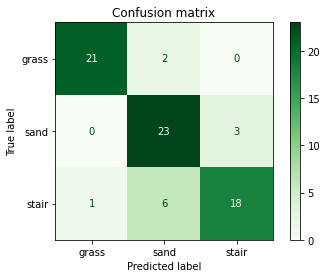

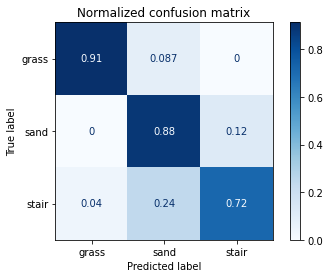

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X[vars], y, test_size =0.20)

model = RidgeClassifier(alpha=best_hyperparameter)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(f"Test score: {model.score(X_test, y_test):0.2f}")

plot_confusion_matrix(model, X_test, y_test, cmap='Greens', values_format='d')  
plt.title("Confusion matrix")
plt.show()

plot_confusion_matrix(model, X_test, y_test, cmap='Blues', normalize='true')  
plt.title("Normalized confusion matrix")
plt.show()

In [264]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       grass       0.95      0.91      0.93        23
        sand       0.74      0.88      0.81        26
       stair       0.86      0.72      0.78        25

    accuracy                           0.84        74
   macro avg       0.85      0.84      0.84        74
weighted avg       0.85      0.84      0.84        74



Evaluation of the classifier: Since we have three classes in the data, by guessing our chance to classify an unseen image we would expect success rate of approximately 33 %. Compared to this our classeifer performs better but the classification accuracy is still rather poor. This is particulary the case with stairs.

### kNN – k Nearest Neighbors classifier

k Nearest Neighbors classifier is an alogorithm where classification is based on the data it self. An image will be assigned to the class it has most common features among its k nearest neighbors. Basically each of the training data images is voting for similarity with the image to be classified and we take into account k of these votings.



In [278]:
# values to be adjusted:
hyperparam = range(1,21)
n_feats = 14 # number of features to be selected
folds = 20

# store results
y_true = []
y_preds_K = [] # predictions with outer CV data
best_hyperparam_K = [] # best hyperparameter values according to the accuracy with outer CV data
best_features = [] # features that give the best outer loop predictions

# other adjustments
y=pd.DataFrame(y)
hyperparam_range = hyperparam
kfold_cv = KFold(n_splits=folds, shuffle=True)
outer_fold = 0

# and go!
for train_index, test_index in kfold_cv.split(X):

    outer_fold = outer_fold+1
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    scores = [] # for each hyperparameter store mean accuracy score
    features = [] # for each hyperparameter store features used

    for param in hyperparam_range: # Inner CV: optimize hyperparameter
        inner_scores=[] # for a given hyperparam: accuracy score for each fold
        feat_support=[] # for a given hyperparam: features used to gain the score

        for subtrain_index, subtest_index in kfold_cv.split(X_train):           
            X_subtrain, X_subtest = X_train.iloc[subtrain_index], X_train.iloc[subtest_index]
            y_subtrain, y_subtest = y_train.iloc[subtrain_index], y_train.iloc[subtest_index]

            model = KNeighborsClassifier(n_neighbors = param)
            model.fit(X_subtrain, y_subtrain)
            inner_scores.append(model.score(X_subtest, y_subtest))
            
            # feature selection
            selector = SelectKBest(f_classif, k=n_feats)
            X_subtrain_new = selector.fit_transform(X_subtrain, y_subtrain)
            # select same feats for test
            X_subtest_new = selector.transform(X_subtest)

            # model = KNeighborsClassifier(n_neighbors = param)
            # model.fit(X_subtrain_new, y_subtrain)
            # inner_scores.append(model.score(X_subtest_new, y_subtest)) # Test accuracy for each inner fold
            feat_support.extend(selector.get_support(indices=True)) # get votes for the features used in selecting the hyperparam

        # print(f"Feature support for hyperparam value {k:0.2f} is {feat_support}") # best feats of the inner loopa are the most common ones in this list
        # print(f"Mean score for hyperparam value {k:0.2f} is {(np.mean(inner_scores)):0.2}")
        scores.append(np.mean(inner_scores)) # mean of inner scores
        features.append(feat_support) # most used features (occurences not counted yet!)
        # features.append(Counter(feat_support).most_common(n_feats)) # the most used features in inner loop

    # back to outer loop, store best hyperparam and best features and predict with them:  
    # print("-------")
    # print(f"Outer fold number {outer_fold}")
    # print(f"The best hyperparam is {hyperparam_range[np.argmax(scores)]:0.2f}")
    # print(f"It was selected with features {features[np.argmax(scores)]}") # get the votes by counting occurences

    best_hyperparam_K.append(hyperparam_range[np.argmax(scores)]) # for the given outer loop fold store the best hyperparameter 
    # best_features.append(features[np.argmax(scores)])
    # best_features.append(Counter(features).most_common(n_feats))
    # feature_indices = [a for (a, b) in Counter(features[np.argmax(scores)]).most_common(n_feats)] # get the most used features
    
    model = KNeighborsClassifier(n_neighbors=hyperparam_range[np.argmax(scores)]) # initialize a model with the best hyperparam
    model.fit(X_train, y_train) # train it with the best features
    predictions = model.predict(X_test) # predict wit the same features

    # model = KNeighborsClassifier(n_neighbors=hyperparam_range[np.argmax(scores)]) # initialize a model with the best hyperparam
    # model.fit(X_train.iloc[:,feature_indices], y_train) # train it with the best features
    # predictions = model.predict(X_test.iloc[:,feature_indices]) # predict wit the same features
    print(f"Performance accuracy was {round(accuracy_score(y_test[0], predictions)*100,1)} percent")
    print("-------\n")

    y_preds_K.extend(predictions) # store predictions...
    y_true.extend(y_test[0].tolist()) # ...and accuracies for later performance measure

Performance accuracy was 84.2 percent
-------

Performance accuracy was 73.7 percent
-------

Performance accuracy was 78.9 percent
-------

Performance accuracy was 94.7 percent
-------

Performance accuracy was 84.2 percent
-------

Performance accuracy was 68.4 percent
-------

Performance accuracy was 84.2 percent
-------

Performance accuracy was 78.9 percent
-------

Performance accuracy was 89.5 percent
-------

Performance accuracy was 89.5 percent
-------

Performance accuracy was 100.0 percent
-------

Performance accuracy was 83.3 percent
-------

Performance accuracy was 77.8 percent
-------

Performance accuracy was 94.4 percent
-------

Performance accuracy was 94.4 percent
-------

Performance accuracy was 88.9 percent
-------

Performance accuracy was 88.9 percent
-------

Performance accuracy was 94.4 percent
-------

Performance accuracy was 83.3 percent
-------

Performance accuracy was 88.9 percent
-------



In [279]:
print(f"Expected classification accuracy: {(accuracy_score(y_true, y_preds_K)*100):0.1f} percent")

Expected classification accuracy: 85.9 percent


In [280]:
# what hyperparameter was the best one?
print("Hyperparameter:")
for i in np.unique(best_ks_K):
    print(i, "voted", best_ks_K.count(i), "time(s)")

Hyperparameter:
1 voted 5 time(s)


In [269]:
# Code partially adopted from UTU Machine Learning and Pattern Recognition course

# data type conversions
X = np.array(X)
y = np.array(y)

k_range = range(1,31)
kfold_cv = KFold(n_splits=5, shuffle=True)

y_true = []
y_preds_K = []
best_ks_K = []

for train_index, test_index in kfold_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scores = [] # for each k store mean accuracy scores
    for k in k_range: # Inner CV: optimize number of neighbors aka hyperparameter
        inner_scores=[] # for given k: accuracy score for each fold
        for subtrain_index, subtest_index in kfold_cv.split(X_train):
            
            X_subtrain, X_subtest = X_train[subtrain_index], X_train[subtest_index]
            y_subtrain, y_subtest = y_train[subtrain_index], y_train[subtest_index]
            
            knn = KNeighborsClassifier(n_neighbors = k)
            knn.fit(X_subtrain, y_subtrain)
            inner_scores.append(knn.score(X_subtest, y_subtest)) # Mean test accuracy for each k for each fold
         
        scores.append(np.mean(inner_scores)) 
             
    # back to outer loop:    
    best_ks_K.append(k_range[np.argmax(scores)]) # for the given outer loop fold store the k which gave the best accuracy 
    knn = KNeighborsClassifier(n_neighbors=k_range[np.argmax(scores)]) # train the model with the best k
    knn.fit(X_train, y_train)
    
    y_preds_K.append(knn.predict(X_test)) # store predictions...
    y_true.append(y_test) # ...and accuracies for performance measure

In [271]:
for i in np.unique(best_ks_K):
    print("K-value:", i, "voted ", best_ks_K.count(i), "times")

# flatten the predicted and true values to lists
pred = []
for array in y_preds_K:
    for item in array:
        pred.append(item)
        
true = []
for array in y_true:
    for item in array:
        true.append(item)

print("Expected classification accuracy: ", round(accuracy_score(true, pred)*100,1), "percent")

K-value: 1 voted  5 times
Expected classification accuracy:  81.4 percent


In [214]:
# what hyperparameter was the best one?
print("Hyperparameter:")
for i in np.unique(best_ks_K):
    print(i, "voted", best_ks_K.count(i), "time(s)")

# use hyperparameter indices to get the best features:
counts = Counter(best_ks_K).most_common()
best_hyperparameter = counts[0][0] # best hyperparameter. In a tie situation the Counter chooses the first item.
print(f"Best hyperparemater is {best_hyperparameter:0.2f}.")
idx  = [i for i, x in enumerate(best_ks_K) if x == best_hyperparameter]

# best features are the ones that were used when training for the best hyperparm:
best_feats = []
for i in idx:
  best_feats.extend(best_features[i]) 
             
feats_of_best_hparam = Counter(best_feats).most_common(n_feats)
col_indices=[a for (a,b) in feats_of_best_hparam]
vars = [all_featurenames[i] for i in col_indices ]

print("The best variables are:")
pprint(vars)

Hyperparameter:
0.09287464307105926 voted 5 time(s)
0.13801118920922653 voted 2 time(s)
0.2050838390019095 voted 1 time(s)
0.30475341355111885 voted 2 time(s)
0.4528618321319532 voted 2 time(s)
0.672950096316178 voted 3 time(s)
1.0 voted 1 time(s)
2.208179027347624 voted 1 time(s)
3.28134142403055 voted 2 time(s)
4.8760546168179015 voted 1 time(s)
Best hyperparemater is 0.09.
The best variables are:
['red mean',
 'green mean',
 'blue mean',
 'red var',
 'green var',
 'blue var',
 'h_90_correlation',
 'h_120_correlation',
 'h_150_correlation',
 'v_210_correlation',
 'd_270_correlation',
 'v_270_correlation',
 'd_210_correlation',
 'v_240_correlation']


The classification accuracy (approximately 73 % percent of the classifications went correctly) is rather poor. We can take a closer look at the succesfull and unsuccessfull classifications with confusion matrix. Confusion matrix has the true labels on rows and predicted labels on columns in sorted order.

In [ ]:
# labels = ['grass', 'sand', 'stair']
# cnf_matrix = confusion_matrix(y, outer_pred, labels)
# print(cnf_matrix)

 ### Multi-layer perceptron

Next we will build a multi-layer perceptron (MLP). MLP is an artificial neural network (NN) which consists  of connected layers of parallel neurons. The idea of NN is to imitate the functionality of human brain and so called parallel processing, the ability to run multiple tasks simultaneously. 

A neural network can have multiple so called hidden layers but since they are computationally expensive to train and extra layers usually bring only limited improvemet we will settle with one hidden layer. Two other layers are the input layer, wich will have as many neurons as we have images, and output layer, consisting of three neurons, since we have three possible classes for the images. Neurons are the computational units of the algorithm. During the training process we have to optimize the number of neurons in the hidden layer.

As we feed in the data the algorithm will initialize weight for each one of the features in the data. The weight determines how important the feature at hand is in predicting the class of the image. We will apply nonlinearity to the model with rectified linear unit function ('relu'). Without this activation function each hidden layer neuron would act like a single linear regression model.

The output of the MLP is a propability for each image to belong to a certain class. Once the data has passed trough the MLP layers, MLP will compare the predicted and true classes of the images in the training data. This comparicon tells how much the pedictions deviate from the true classes. This error is then used to update the weights the MLP uses to predict the classes. This is done by Adam, a stochastic gradient-based optimizer. Once the weights are updated the learning process is repeated. This means that MLP is an iterative algorithm. We terminate the training when the accuracy of the MLP is not improving. The "early stop" parameter is used for this purpose.

In [ ]:
# We expect the optimal size of the hidden layer to be between the sizes of the output and input layers. 
# For finding the lower boundary for the range to be searhced some preliminary exploration was done.

neurons = range(100, 186, 4)

parameters={'hidden_layer_sizes':neurons}

In [ ]:
mlp = MLPClassifier(early_stopping=True,
                    activation='relu', solver='adam', random_state=1, n_iter_no_change = 3)

inner_cv = KFold(n_splits=25, shuffle=True, random_state=4) 
outer_cv = KFold(n_splits=25, shuffle=True, random_state=4)

gscv = GridSearchCV(mlp, parameters, return_train_score=False, cv=inner_cv)
gscv.fit(X, y)

outer_score = cross_val_score(gscv, X=X, y=y, cv=outer_cv)
outer_pred = cross_val_predict(gscv, X=X, y=y, cv=outer_cv)

# alphafloat, default=0.0001 L2 penalty (regularization term) parameter.


In [ ]:
print("Best parameter value:", gscv.best_params_)
print()
print("Classification accuracy: ", round((outer_score.mean())*100,1), "percent")

Best parameter value: {'hidden_layer_sizes': 152}

Classification accuracy:  59.5 percent


In [ ]:
cnf_matrix = confusion_matrix(y, outer_pred, labels)
# Confusion matrix has the true labels on rows, and predicted labels on columns in sorted order
print(cnf_matrix)

[[38 12 12]
 [ 7 50  4]
 [20 20 22]]


Normalized confusion matrix
[[0.61290323 0.19354839 0.19354839]
 [0.1147541  0.81967213 0.06557377]
 [0.32258065 0.32258065 0.35483871]]


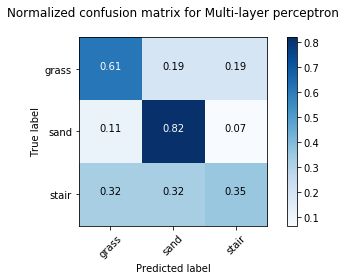

In [ ]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = labels, normalize = True,
                      title='Normalized confusion matrix for Multi-layer perceptron\n')

plt.show()

## Discussion

From the classifiers we built, k Nearest Neighbors, Ridge classifier and Multi-Layer Perceptron, Ridge classifier made the most accurate predictions. Simple models can outperform more complicated ones.

The performance of the classifier depends also on the data it trains with. We could have extracted more features or tune the existing ones. For all of the classifiers predicting the class "stairs" was the most difficult task. If we had extracted more features which clearly distinc stairs from sand and grass we could have performed better.

Also the size of our data set was rather modest. With more data our models would have more to train with and to learn about and thus they might be able to make more accurate predictions.

The cross validation algorithm used in nested cross validation to optimize the model affects the results to some limit. The division of data to training and test set in inner and outer loops of CV affects the optimization of the hyperparameter (number of neighbors in kNN, regularization strength in Ridge regression, number if hidden units in MLP) for each of the classifiers. We used KFold and tried to avoid these caveats with suffle and stratification.

Computationally heavy Leave One Out (LOO) cross validation would have opitimized the hyperparameter for each image. In our case we settled in KFold cross validation where the data is folded or split to a given number of subsets. The number of subsets and the data ending up in each subset affects the training and received hyperparameter values. Different folds (5, 10 and 25) were tried and compared to LOO. Since the accuracy of more heavy algorithms was limited, KFold with 25 folds was used.